## Importing modules and libraries

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Loading the dataset (intents.json)

In [ ]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [ ]:
data = load_doc('intents.json')

## Extracting questions from dataset into a pandas dataframe

In [ ]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [ ]:
# users intents 
df1 = frame_data('questions','labels',True)
print(df1.shape)
df1.head()

(422, 2)


,questions,labels
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
df1.labels.value_counts(sort=False)

infrastructure          3
placement               8
canteen                10
hostel                 22
document               13
ragging                 8
managementhod           6
library                12
creator                16
college intake          9
Ph.D.                  10
ithod                   6
transport               9
B.Tech.                10
salutaion              12
random                  3
architecture hod        6
admission               6
csehod                  6
aihod                   6
vacation               10
metro                   8
floors                  7
ecehod                  6
sem                    11
M.Tech                 10
greeting                9
uniform                 9
syllabus               12
number                 15
name                   13
mechhod                 6
facilities              5
location               14
hours                  17
event                  11
Chancellor              8
course                 17
task        

## Extracting responses from dataset into a pandas dataframe

In [ ]:
# Bot response
df2 = frame_data('response','labels',False)
print(df2.shape)
df2.head()

(59, 2)


,response,labels
0,Hello!,greeting
1,Good to see you again!,greeting
2,"Hi there, how can I help?",greeting
3,Sad to see you go :(,goodbye
4,Talk to you later,goodbye


## Text Pre-processing

### Tokenization and Lemmatization

**Tokenization** is the act of splitting a text corpus into constitute words—i.e splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units is called a token. Tokenization can be done manually by splitting based on white space or by using dedicated tools in libraries such as NLTK. 

**Lemmatization** is a common normalization technique in text pre-processing. In lemmatization, words are replaced by their root form or words with similar context. Another text normalization technique similar to this is called stemming. This is often done alongside manual tokenization so as to yield useful tokens.

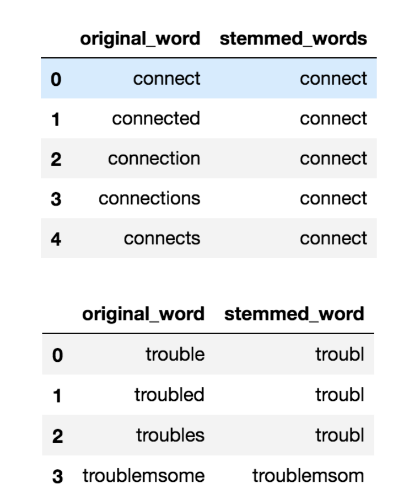

The function below was used to tokenize and lemmatize our corpus:

In [ ]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

### Removing Stop Words

It’s also good practice to remove stop words from tokens so as to avoid misleading the model. Stop words are words that do not contribute to the deeper meaning of the phrase—definite and indefinite articles, pronouns, and conjunctions to mention a few.
With the NLTK library, filtering out stop words is easy, and you can also add words that you feel should be a stop word into the predefined set of words in the library.

In [ ]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

### Vocabulary Building

Once we remove the stop words, the text is becoming cleaner, and at least halfway ready for modeling. Our next step is to build a vocabulary, which is a set of words in a given dataset after the removal of stop words. This will come in very handy during data encoding.

In [ ]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [ ]:
print(vocab.most_common(20))

[('is', 84), ('college', 73), ('what', 54), ('hod', 49), ('the', 45), ('of', 40), ('you', 35), ('how', 31), ('in', 31), ('are', 25), ('name', 22), ('hostel', 22), ('who', 19), ('where', 18), ('to', 17), ('fee', 16), ('for', 16), ('available', 15), ('facility', 15), ('can', 14)]


In [ ]:
vocab_size = len(vocab)
vocab_size

252

In [ ]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['how many btech stream',
 'what is the name of vice chancellor',
 'how many mtech stream',
 'how many phd stream',
 'what is the process of admission',
 'who is ai hod',
 'who is applied science hod',
 'who is architecture department hod',
 'food facility',
 'max number of student',
 'what are the different committe in college',
 'list of course',
 'what is the name of your developer',
 'who is cse hod',
 'document to bring',
 'who is ece hod',
 'event organised',
 'what facility college provide',
 'information about fee',
 'size of campus',
 'cya',
 'hi',
 'hod',
 'hostel facility',
 'timing of college',
 'how is college infrastructure',
 'who is it hod',
 'is there any library',
 'where is the college located',
 'who is management hod',
 'who is mechanical hod',
 'food menu',
 'nearest metro station',
 'name',
 'more info',
 'what is college placement',
 'ragging',
 'love you',
 'okk',
 'exam date',
 'syllabus for it',
 'what can you do',
 'dtc bus route',
 'college dress code',
 'h

In [ ]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[99,
 309,
 109,
 119,
 328,
 303,
 260,
 285,
 237,
 339,
 357,
 82,
 21,
 267,
 190,
 273,
 179,
 334,
 129,
 203,
 9,
 0,
 402,
 157,
 50,
 234,
 279,
 222,
 143,
 297,
 291,
 247,
 414,
 37,
 67,
 252,
 394,
 363,
 376,
 317,
 210,
 388,
 405,
 348,
 366]

In [ ]:
train_index = [i for i in df1.index if i not in test_index]

In [ ]:
' '.join(list(vocab.keys()))

'hi how are you is anyone there hello good day whats up ya heyy whatsup cya see bye later goodbye am leaving have talk to tyyl got go gtg what the name of your developer creator who created made by whom create designed do called should call this chatting taking timing college working when guy open hour operation about on saturday tell something come attend my time more info contact telephone number no phone can get list course offered in igdtuw offer branch available at me many btech stream field type mtech phd information fee per semester each year much for first where located address reach location wheres hostel facility servive doe provide any capacity far from distance big between and event organised conducted held function document bring needed admision admission during required which need size campus building floor tall syllabus it technology timetable next lecture computer science holiday ece library book infrastructure food canteen cafetaria menu we placement company visit aver

## Encoding and Decoding

Now that we have a vocabulary of words in the dataset, each of the patterns can be encoded into numerical features for modeling, using any of the common text encoding techniques—count vectorizer, term frequency-inverse document frequency (TF-IDF), hashing, etc.
Using TensorFlow.Keras text_to_sequence, we can encode each pattern corpus to vectorize a text corpus by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count which is based on **TF-IDF**. The resulting vectors will be post-padded with zeros so as to equal the length of the vectors.

In [ ]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [ ]:
X,vocab_size = encoder(df1,'questions')

In [ ]:
vocab_size

253

In [ ]:
df_encoded = pd.DataFrame(X)

In [ ]:
df_encoded['labels'] = df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,labels
0,155,0,0,0,0,0,0,0,0,greeting
1,8,10,7,0,0,0,0,0,0,greeting
2,1,156,31,0,0,0,0,0,0,greeting
3,157,0,0,0,0,0,0,0,0,greeting
4,90,91,0,0,0,0,0,0,0,greeting


In [ ]:
for i in range(0,2):
    dt = [0]*16
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {16:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [ ]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,labels,9,10,11,12,13,14,15
419,154,51,58,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,51,0,0,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,51,58,154,0,0,0,0,0,0,metro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,0,0,0,0,0,0,0,0,0,confused,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0,0,0,0,0,0,0,0,0,confused,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_encoded.fillna(0, inplace = True)

#### train test split

In [ ]:
train_index.append(422)

In [ ]:
test_index.append(423)

#### Converting dataset to machine readable form using label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [ ]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20,
       20, 20, 20, 20, 20, 20, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 28, 28, 28, 28

#### encoding `['label']` to machine readable form

In [ ]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'B.Tech.': 0,
 'Chancellor': 1,
 'M.Tech': 2,
 'Ph.D.': 3,
 'admission': 4,
 'aihod': 5,
 'applied science hod': 6,
 'architecture hod': 7,
 'canteen': 8,
 'college intake': 9,
 'committee': 10,
 'confused': 11,
 'course': 12,
 'creator': 13,
 'csehod': 14,
 'document': 15,
 'ecehod': 16,
 'event': 17,
 'facilities': 18,
 'fees': 19,
 'floors': 20,
 'goodbye': 21,
 'greeting': 22,
 'hod': 23,
 'hostel': 24,
 'hours': 25,
 'infrastructure': 26,
 'ithod': 27,
 'library': 28,
 'location': 29,
 'managementhod': 30,
 'mechhod': 31,
 'menu': 32,
 'metro': 33,
 'name': 34,
 'number': 35,
 'placement': 36,
 'ragging': 37,
 'random': 38,
 'salutaion': 39,
 'sem': 40,
 'syllabus': 41,
 'task': 42,
 'transport': 43,
 'uniform': 44,
 'vacation': 45}

#### mapping encoded labels to responses dataset and saving it as csv for future use

In [ ]:
df2.labels = df2.labels.map(mapper)

In [ ]:
df2.dropna(inplace=True)

In [ ]:
df2.labels = df2.labels.astype({'labels': 'int32'})

In [ ]:
df2.head()

,response,labels
0,Hello!,22
1,Good to see you again!,22
2,"Hi there, how can I help?",22
3,Sad to see you go :(,21
4,Talk to you later,21


In [ ]:
df2.to_csv('response.csv',index=False)

### Data Splitting

With the data encoded, we can now split it into training and testing sets. The training set will be used to train the model while the testing set will be used for evaluating its performance on unseen data. This can be done using a stratified approach, whereby of the patterns in the tags are well represented in the testing set.

In [ ]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [ ]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [ ]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [ ]:
y_train[0].shape,y_test[0].shape 

((46,), (46,))

In [ ]:
X_train.shape

(378, 16)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(378, 16) (378, 46) (46, 16) (46, 46)


In [ ]:
max_length = X_train.shape[1]
output = 46

In [ ]:
max_length

16

## Model Architecture

The most common approach to building a model on sequence input is to use a reinforcement learning model—we’ll use a long-short-term-memory (LSTM) architecture due to its state-of-the-art performance. The choice for this project is a convolutional neural network (CNN) + an embedding layer + fully connected layer.

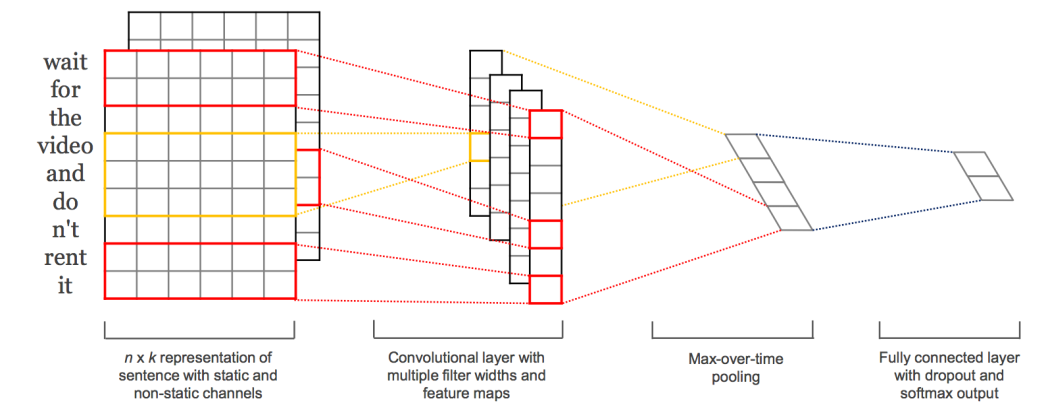

A word embedding is a method of representing text in which each word in the vocabulary is represented by a real-valued vector in a high-dimensional space. These vectors are learned in such a way that words that have similar meanings will have similar representations in the vector space.
This has been proven as a better representation for text than normal classical methods like bag-of-words, where relationships between words or tokens are ignored, or forced in bigram and trigram approaches. These vectors are learned and updated during the model training.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [ ]:
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,600, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
    model.add(Dense(output, activation='softmax'))
    
    
    # compile network
    model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 600)           151800    
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 64)            153664    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 46)                2990      
Total params: 308,454
Trainable params: 308,454
Non-trainable params: 0
_________________________________________________________________


As seen in the code snippet above, the vector output of the embedding layer is 600 and followed by a 1-dimensional convolution layer using 64 filters with kernel size of 4, each using a ReLU activation function.
Then, a 1-dimensional max pooling layer with a pool size of 8. These vectors are fattened (transposed to a single row of vectors) for the fully connected layer before compiling it with an Adam optimizer. These parameters are a result of several iterative processes, with the aim being to get the best model architecture for the dataset at hand. The model summary can be seen above.

## Training the model

In [ ]:
history = model.fit(X_train, y_train, epochs=50, verbose=2,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/50
12/12 - 0s - loss: 0.1517 - accuracy: 0.9894 - val_loss: 1.0419 - val_accuracy: 0.7391

Epoch 00001: val_loss improved from 1.18657 to 1.04195, saving model to model-v1.h5
Epoch 2/50
12/12 - 0s - loss: 0.1186 - accuracy: 0.9894 - val_loss: 0.9980 - val_accuracy: 0.7391

Epoch 00002: val_loss improved from 1.04195 to 0.99804, saving model to model-v1.h5
Epoch 3/50
12/12 - 0s - loss: 0.0959 - accuracy: 0.9921 - val_loss: 0.9508 - val_accuracy: 0.7391

Epoch 00003: val_loss improved from 0.99804 to 0.95083, saving model to model-v1.h5
Epoch 4/50
12/12 - 0s - loss: 0.0795 - accuracy: 0.9921 - val_loss: 0.9265 - val_accuracy: 0.7391

Epoch 00004: val_loss improved from 0.95083 to 0.92650, saving model to model-v1.h5
Epoch 5/50
12/12 - 0s - loss: 0.0675 - accuracy: 0.9921 - val_loss: 0.9022 - val_accuracy: 0.7391

Epoch 00005: val_loss improved from 0.92650 to 0.90222, saving model to model-v1.h5
Epoch 6/50
12/12 - 0s - loss: 0.0594 - accuracy: 0.9921 - val_loss: 0.8850 - val_accu

Accuracy of model:  76.0869562625885 %


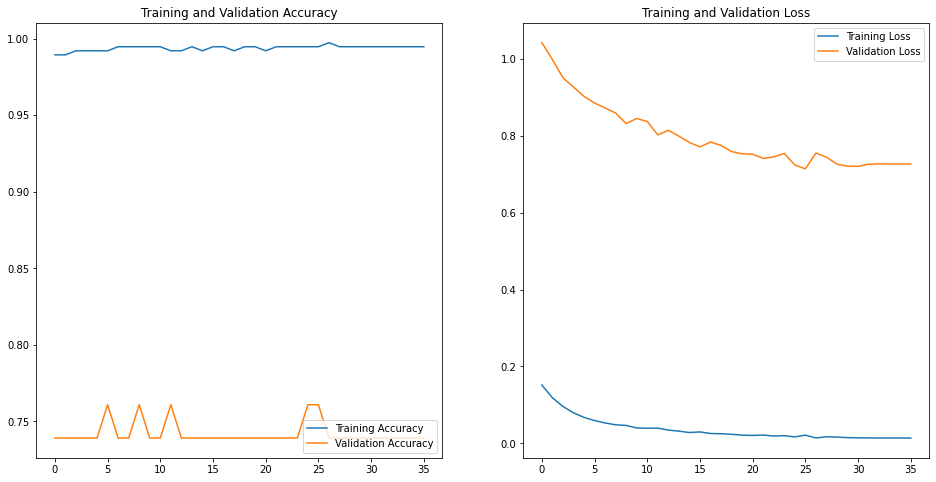

In [ ]:
print("Accuracy of model: ",max(history.history['val_accuracy'])*100, "%")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## New user question encoding

In [ ]:
def get_text():
    input_text  = input('User: ')
    input_text = [input_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input 

In [ ]:
#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [ ]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [ ]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [ ]:
# df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
# df_input

In [ ]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=16, padding='post')
    return padded

In [ ]:
# encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
# encoded_input.shape

In [ ]:
# encoded_input

In [ ]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [ ]:
# mapper

In [ ]:
# df2.head()

In [ ]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [ ]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
    

In [ ]:
def bot_response(response,):
    print('Smart Bot: ', response)

In [ ]:
while True:
  df_input = get_text()

  if df_input['questions'][0].lower() == 'quit':
    break

  #load artifacts 
  tokenizer_t = joblib.load('tokenizer_t.pkl')
  vocab = joblib.load('vocab.pkl')

  df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
  encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

  pred = get_pred(model,encoded_input)
  pred = bot_precausion(df_input,pred)

  response = get_response(df2,pred)
  bot_response(response)

User: hello
Smart Bot:  Good to see you again!
User: Where is IGDTUW?
Smart Bot:  Indira Gandhi Delhi Technical University For Women, Madrasa Road ,Opposite St. James Church Kashmere Gate,Delhi-110006<a target="_blank" href="https://goo.gl/maps/YMrH73Pyuyoc21jLA"> here</a> 
User: How do I get there?
Smart Bot:  Hi there, how can I help?
User: Who is the VC?
Smart Bot:  HODs differ for each branch, please be more specific like: (HOD it)
User: Tell me about B.Tech
Smart Bot:   University offers Btech in 5 streams 1. Computer science and artificial Intelligence(CSAI) 
 2. Computer science engineering (CSE) 
 3.Information Technology(IT) 
 4. Electronics and Communication(ECE) 
 5.Mechanical and Automation(MAE)
User: quit


In [ ]:
!pip3 install SpeechRecognition pydub

     |████████████████████████████████| 32.8 MB 35 kB/s 


In [ ]:
!pip3 install sounddevice

In [ ]:
!pip3 install wavio

In [ ]:
!pip3 install scipy

In [ ]:
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (152 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 160837 files

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudiocpp0 portaudio19-dev
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 120 kB of archives.
After this operation, 676 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 120 kB in 1s (184 kB/s)
Selecting previously unselected package libportaudiocpp0:amd64.
(Reading database ... 160843 files and directories currently installed.)
Preparing to unpack .../libportaudiocpp0_19.6.0-1_amd64.deb ...
Unpa

In [ ]:
!pip3 install pyaudio

  Using cached PyAudio-0.2.11.tar.gz (37 kB)
  Created wheel for pyaudio: filename=PyAudio-0.2.11-cp37-cp37m-linux_x86_64.whl size=52605 sha256=b46044c9166be18d70e97055de8dc0c75ebaee2b0b8dc79180bd6bfe366d0839
  Stored in directory: /root/.cache/pip/wheels/40/2e/4c/b71e7e96c861a46e6213bc6bb482b94dcf293a92c5e736c1ec
Successfully built pyaudio


In [ ]:
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import pyaudio

In [ ]:
import speech_recognition as sr

In [ ]:
def recognize_speech_from_mic(recognizer, microphone):
    """Transcribe speech from recorded from `microphone`.
    Returns a dictionary with three keys:
    "success": a boolean indicating whether or not the API request was
               successful
    "error":   `None` if no error occured, otherwise a string containing
               an error message if the API could not be reached or
               speech was unrecognizable
    "transcription": `None` if speech could not be transcribed,
               otherwise a string containing the transcribed text
    """
    # check that recognizer and microphone arguments are appropriate type
    if not isinstance(recognizer, sr.Recognizer):
        raise TypeError("`recognizer` must be `Recognizer` instance")

    if not isinstance(microphone, sr.Microphone):
        raise TypeError("`microphone` must be `Microphone` instance")

    # adjust the recognizer sensitivity to ambient noise and record audio
    # from the microphone
    with microphone as source:
        recognizer.adjust_for_ambient_noise(source) # #  analyze the audio source for 1 second
        audio = recognizer.listen(source)

    # set up the response object
    response = {
        "success": True,
        "error": None,
        "transcription": None
    }

    # try recognizing the speech in the recording
    # if a RequestError or UnknownValueError exception is caught,
    #   update the response object accordingly
    try:
        response["transcription"] = recognizer.recognize_google(audio)
    except sr.RequestError:
        # API was unreachable or unresponsive
        response["success"] = False
        response["error"] = "API unavailable/unresponsive"
    except sr.UnknownValueError:
        # speech was unintelligible
        response["error"] = "Unable to recognize speech"

    return response

In [ ]:
recognizer = sr.Recognizer()
mic = sr.Microphone()
response = recognize_speech_from_mic(recognizer, mic)
print('\nSuccess : {}\nError   : {}\n\nText from Speech\n{}\n\n{}' \
  .format(response['success'],
    response['error'],
    '-'*17,
    response['transcription']))

AssertionError: ignored